<a href="https://colab.research.google.com/github/Benendead/LSTMjazz/blob/master/Research/My_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Author(s) | Year | Models Used | Music | Encoding | Quantization | Future work | Code/Examples
--- | ---
Eck | 2002 | LSTM | Melody + chords | 13 melody, 12 chord 1/0 | 2 per beat | N/A | [Ex](https://web.archive.org/web/20190104192500/http://people.idsia.ch/~juergen/blues/)
Bickerman | 2010 | DBN | Chords -> jazz licks | 18 melody (12 pitch, 4 8va), 12 chord | 12 per beat | Melodies avoid triplets | [Code](https://sourceforge.net/projects/rbm-provisor/)
Choi | 2016 | char-RNN, word-RNN | Jazz chord progressions | Note chars, Chord words | 1 per beat | N/A | [Code](https://github.com/keunwoochoi/lstm_real_book)
Lackner | 2016 | LSTM | Melody given chords | 24 melody, 12 chord 1/0 | 4 per beat | Larger dataset | [Ex](https://konstilackner.github.io/LSTM-RNN-Melody-Composer-Website/)
Agarwala | 2017 | Seq2Seq, char-RNN | Melodies | ABC char -> embeddings | None; ABC notation | N/A | [Code](https://github.com/yinoue93/CS224N_proj)
Brunner | 2017 | 2 LSTMs | Chords -> polyphonic piano | 48 melody, 50 chord embeddings | 2 per beat | Encoding polyphonic sustain, genre metadata | N/A
Hilscher | 2018 | char-RNN | Polyphonic piano | 1/0 on/off vectors | 4 per beat | More keys/data, text pattern matching | [Ex](https://yellow-ray.de/~moritz/midi_rnn/examples.html)

**To Consider:**
* My representation needs to have at least 12 steps per beat; triplets AND sixteenth notes are needed.
* Chords --> Melody has only one precedent for best practices.
* 2 of the 7 used chord embeddings.
* Methods to check overfitting are limited so far.
* 3 of the 7 benefitted from transposing to multiple keys.

# Representation Decisions

**Chords**  
We've really seen a few options for chords. These include:
* Text representations of chords quantized to quarter notes:  
 -START- F:9 F:9 F:9 F:9 D:min7 D:min7 G:9 G:9 C:maj C:maj F:9 F:9 C:maj C:maj C:maj C:maj -END-
* 0-11 bit vector encoding.
* Chord embeddings from unique bit vectors - Based on bits or on tokens? (Tokens better)



# Code Setup and Data Import

We import the necessary libraries, create a method to tranpose imported songs to C, and then import all songs.

In [1]:
!pip install music21

import music21 as m21
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

!git clone https://github.com/Benendead/LSTMjazz/

Cloning into 'LSTMjazz'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 308 (delta 88), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (308/308), 1.45 MiB | 5.48 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [0]:
def formatStream(stream):
  m21.harmony.realizeChordSymbolDurations(stream)           # Fills out chords' proper durations.
  key = stream.analyze("key")                               # Finds how far off we are from C.
  i = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
  transposedStream = stream.transpose(i)                    # Transposes us that far to C.
  return transposedStream

In [3]:
# Import the songs and transpose them all to C.

streams = []
names = []
i = 1

start = time.process_time()
# Selects all .xml files in the Datasets folder.
for xml_file in glob.glob("LSTMjazz/Datasets/*/*.xml"):
    if (i == 1 or i % 10 == 0):
      elapsed = "{0:.2f}".format(time.process_time() - start)
      print("Processing song", i, ":", xml_file, "(" + elapsed + " seconds elapsed)")
    newSong = m21.converter.parse(xml_file)
    formattedSong = formatStream(newSong)
    streams.append(formattedSong)
    songName = xml_file[32:-4]  # Formats xml_file to get the name of the song.
    names.append(songName)
    i = i + 1
print("Process complete.")

Processing song 1 : LSTMjazz/Datasets/Omnibook Mxml/Warming_Up_A_Riff.xml (0.00 seconds elapsed)
Processing song 10 : LSTMjazz/Datasets/Omnibook Mxml/Cosmic_Rays.xml (18.67 seconds elapsed)
Processing song 20 : LSTMjazz/Datasets/Omnibook Mxml/Shawnuff.xml (38.10 seconds elapsed)
Processing song 30 : LSTMjazz/Datasets/Omnibook Mxml/Segment.xml (55.78 seconds elapsed)
Processing song 40 : LSTMjazz/Datasets/Omnibook Mxml/Au_Private_2.xml (73.47 seconds elapsed)
Processing song 50 : LSTMjazz/Datasets/Omnibook Mxml/Card_Board.xml (91.71 seconds elapsed)
Process complete.


We now have all songs imported, transposed to C, and with fully realized chord durations.  
Rather than one copy of each song in C, let's create 12 copies of each song transposed to all 12 keys.  
(I also include a method to transpose a song to a random key, as I'd already written the code.)

In [0]:
import random

def transposeRandom(stream):
  """
  Transposes a given stream to a random key.
  """
  half_steps = random.randint(0,12) # Random number 0 to 11.
  i = m21.interval.Interval(half_steps)
  transposedStream = stream.transpose(i)
  return transposedStream

In [0]:
def transpose12(stream):
  """
  Returns a list of all 12 tranpositions of the given stream.
  """
  output = []
  for k in range(0,12):
    half_steps = k
    i = m21.interval.Interval(half_steps)
    transposedStream = stream.transpose(i)
    output.append(transposedStream)
  return output

In [6]:
expanded_streams = [] # This will have every transposed song in it; 600 total.

start = time.process_time()
for stream_n in range(0,len(streams)):
  s = streams[stream_n]
  if (stream_n == 0 or stream_n % 5 == 4):
    elapsed = "{0:.2f}".format(time.process_time() - start)
    print("Replicating song", (stream_n + 1), "of 50. (" + elapsed + " seconds elapsed)")
  transposed_list = transpose12(s)
  expanded_streams.extend(transposed_list)
    
print("We have", len(expanded_streams), "total songs.")

Replicating song 1 of 50. (0.00 seconds elapsed)
Replicating song 5 of 50. (28.98 seconds elapsed)
Replicating song 10 of 50. (53.17 seconds elapsed)
Replicating song 15 of 50. (75.08 seconds elapsed)
Replicating song 20 of 50. (106.44 seconds elapsed)
Replicating song 25 of 50. (128.31 seconds elapsed)
Replicating song 30 of 50. (153.33 seconds elapsed)
Replicating song 35 of 50. (180.01 seconds elapsed)
Replicating song 40 of 50. (201.91 seconds elapsed)
Replicating song 45 of 50. (227.25 seconds elapsed)
Replicating song 50 of 50. (251.46 seconds elapsed)
We have 600 total songs.


# Basic Dataset Analysis

Let's check out how long our songs are, as well as the range of their pitches.

In [0]:
def getDuration(stream):
  """
  Takes a Music21 stream and returns the total length of the chords in the stream.
  """
  part = stream.parts[0]
  sumDuration = 0
  
  for m in part:                                       # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):     # For the chords...
          sumDuration = sumDuration + c.duration.quarterLength
  
  return sumDuration

In [8]:
durations = []

total = 0
for s in expanded_streams:
  duration = getDuration(s)
  durations.append(duration)
  total = total + duration
  
print("We have", total, "total beats of data.")
print("Mean song length is", np.mean(np.array(durations)), "beats.")
print("Median song length is", np.median(np.array(durations)), "beats.")

We have 169008.0 total beats of data.
Mean song length is 281.68 beats.
Median song length is 260.0 beats.


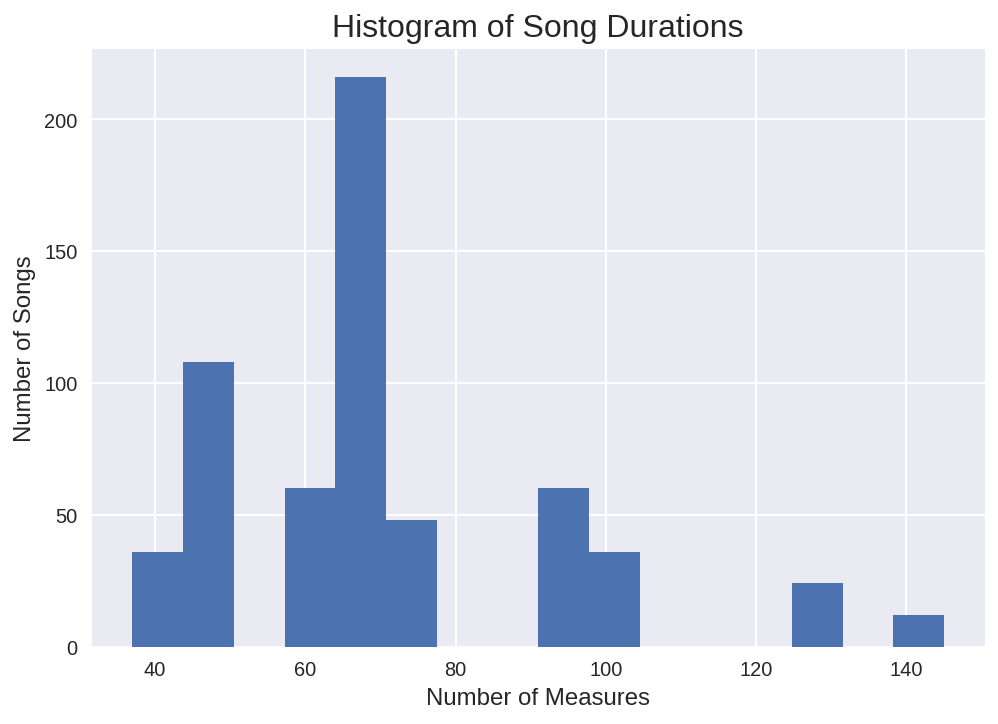

In [9]:
# Some insight into the durations of the songs we have.

n_bins = 16
x = np.array(durations) / 4

fig, ax = plt.subplots()

plt.title("Histogram of Song Durations", fontsize = 16)
plt.xlabel("Number of Measures", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)

hist = ax.hist(x, bins = n_bins) # We can set the number of bins for the histogram with the "bins" kwarg

Let's also check the keys of our now-transposed songs:

In [0]:
def getKey(stream):
  """
  Returns the key of the given stream as an int 0-11, with C = 0 and B = 11.
  """
  key = stream.analyze("key")  # A music21.key.Key object.
  tonic = key.tonic            # A music21.pitch.Pitch object.
  return tonic.pitchClass

In [0]:
key_labels_for_graphs = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

Processing song  1 (0.00 seconds elapsed)
Processing song  50 (3.77 seconds elapsed)
Processing song  100 (7.00 seconds elapsed)
Processing song  150 (10.06 seconds elapsed)
Processing song  200 (13.70 seconds elapsed)
Processing song  250 (16.97 seconds elapsed)
Processing song  300 (24.33 seconds elapsed)
Processing song  350 (27.64 seconds elapsed)
Processing song  400 (30.99 seconds elapsed)
Processing song  450 (34.33 seconds elapsed)
Processing song  500 (37.50 seconds elapsed)
Processing song  550 (40.88 seconds elapsed)
Processing song  600 (44.12 seconds elapsed)


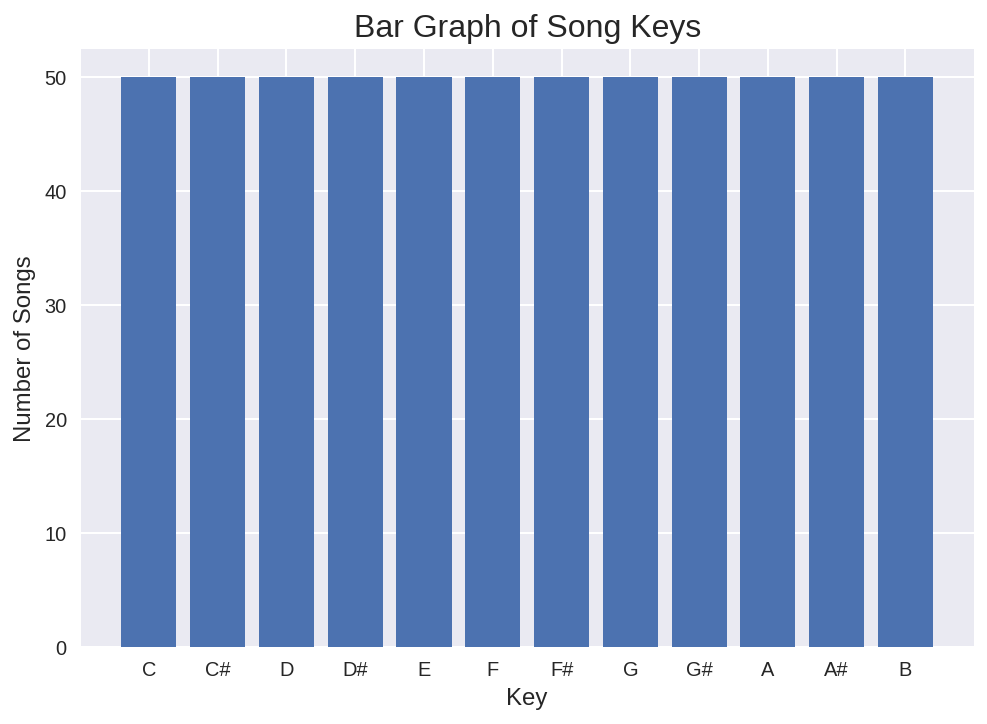

In [12]:
# Some insight into the keys of the songs we have.

keys = [0] * 12
counter = 1

start = time.process_time()
for s in expanded_streams:
  if (counter == 1 or counter % 50 == 0):
    elapsed = "{0:.2f}".format(time.process_time() - start)
    print("Processing song ", counter, "(" + elapsed + " seconds elapsed)")
  k = getKey(s)
  keys[k] = keys[k] + 1
  counter = counter + 1

fig, ax = plt.subplots()

plt.title("Bar Graph of Song Keys", fontsize = 16)
plt.xlabel("Key", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)
plt.xticks(range(0,12), key_labels_for_graphs, fontsize = 10)

bar = ax.bar(range(0,12), keys)

# Considering Chord Encodings

We can see the duration and key of the songs we have, but what other metrics inform us about the melodies and harmonies within these songs? Let's look into what chords these songs now use. First, we want to find the "vocabulary" of the chords present. This entails adding one copy of each unique chord into a list.

### Unique Chord Counting Methods

In [0]:
def uniqueChordsAsTokens(stream):
  """
  Returns a list of tokens representing the unique chords in
  this song. The tokens are the chord symbols.
  """
  chords = []
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...

          symbol = str(c.figure)
          
          if symbol not in chords:
            chords.append(symbol)
  return chords

In [0]:
def combineSets(set1, set2):
  """
  Combines the contents of two sets as to keep all elements unique.
  NOTE: Faster if set2 is the shorter one.
  """
  for e in set2:
    if e not in set1:
      set1.append(e)
  return set1

It's now time to find all unique chords in each song and then merge all 600 of these sets. We need to use token representations of the chords, not bit representations, to keep chord function information bits might otherwise lose.

In [15]:
uniqueChordsTokens = []

counter = 1
start = time.process_time()
for s in expanded_streams:
  if (counter == 1 or counter % 50 == 0):
    elapsed = "{0:.2f}".format(time.process_time() - start)
    print("Working through song " + str(counter) + "'s chords. (" + elapsed + " seconds elapsed)")
  newChords = uniqueChordsAsTokens(s)
  uniqueChordsTokens = combineSets(uniqueChordsTokens, newChords)
  counter = counter + 1
  
print("We have", len(uniqueChordsTokens), "unique chords.")

Working through song 1's chords. (0.00 seconds elapsed)
Working through song 50's chords. (0.36 seconds elapsed)
Working through song 100's chords. (0.60 seconds elapsed)
Working through song 150's chords. (0.81 seconds elapsed)
Working through song 200's chords. (1.13 seconds elapsed)
Working through song 250's chords. (1.38 seconds elapsed)
Working through song 300's chords. (1.62 seconds elapsed)
Working through song 350's chords. (1.89 seconds elapsed)
Working through song 400's chords. (2.15 seconds elapsed)
Working through song 450's chords. (2.40 seconds elapsed)
Working through song 500's chords. (2.62 seconds elapsed)
Working through song 550's chords. (2.91 seconds elapsed)
Working through song 600's chords. (3.15 seconds elapsed)
We have 84 unique chords.


In [16]:
uniqueChords = pd.DataFrame(uniqueChordsTokens)
uniqueChords.head(3).append(uniqueChords.tail(3))

,0
0,G7
1,C
2,Gm
81,E6
82,F6
83,F#6


So there we have it: 84 unique chords. But which of these chords is actually used often? Are there outlier chords that aren't worth encoding?

In [0]:
chordIndices = {}

for i in range(len(uniqueChords)):
  key = uniqueChords.iloc[i,0]
  value = i
  chordIndices[key] = value

def findChordIndex(symbol):
  """
  Finds the index of the given chord symbol within the uniqueChords dataframe.
  """
  return chordIndices[symbol]

In [18]:
findChordIndex("C")

1

### Chord Encoding

In [0]:
# We also need to standardize the subdivision somewhere. We need 12 PPQ, as stated.
subdivide = 12

In [0]:
def findInt(vector):
  return uniqueChordSet.index(vector)

In [0]:
def processChordsToBitVectors(stream):
  """
  Create the 2D numpy array which will represent the chords of this song.
  NOTE: Vertical of the 2D array represents time.
        Horizontal represents the 12 possible chord notes for each tick.
  """
  duration = getDuration(stream)
  
  # subdivide is the number of subdivisions our data and thus model will consider per beat.
  ticks = int(duration * subdivide)  # The total number of "ticks" in this entire song
  
  # Create the numpy array to store the chord data.
  arr = np.zeros((ticks, 12))
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      currOffset = int(m.offset * subdivide)         # This offset is in ticks.
      
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...
          ticksInChord = int(c.duration.quarterLength * subdivide)
          endOfChord = currOffset + ticksInChord
          
          notesInChord = []                          # Keep track of the notes on for this chord...
          for p in c.pitches:
            p.octave = 4
            num = int(p.midi - 60) % 12              # num will range from 0 to 11.
            notesInChord.append(num)
         
          for r in range(currOffset, endOfChord):    # For each row, representing all ticks in this chord...
            for n in notesInChord:                   # Set all the notes in this chord to 1 for these ticks.
              arr[r][n] = 1
          
          currOffset = currOffset + ticksInChord     # Account for two chords in a measure by adding the first chord to the offset.
          
  return arr

In [0]:
def checkRows(arr):
  # Verifies that each row of a 2D array has at least one bit activated.
  for row in arr:
    found = False
    for c in row:
      if (c == 1):
        found = True
    if (not found):
      print("Nothing in this row.")

So we're ready to extract the chords as bit vectors, at least:

In [23]:
chordBitVectors = []

i = 1
start = time.process_time()
for s in expanded_streams:
  if (i == 1 or i % 50 == 0):
    elapsed = "{0:.2f}".format(time.process_time() - start)
    print("Processing song", i, "(" + elapsed + " seconds elapsed)")
  arr = processChordsToBitVectors(s)
  chordBitVectors.append(arr)
  i = i + 1

Processing song 1 (0.00 seconds elapsed)
Processing song 50 (1.08 seconds elapsed)
Processing song 100 (1.81 seconds elapsed)
Processing song 150 (2.44 seconds elapsed)
Processing song 200 (3.42 seconds elapsed)
Processing song 250 (4.19 seconds elapsed)
Processing song 300 (4.88 seconds elapsed)
Processing song 350 (5.66 seconds elapsed)
Processing song 400 (6.43 seconds elapsed)
Processing song 450 (7.18 seconds elapsed)
Processing song 500 (7.85 seconds elapsed)
Processing song 550 (8.69 seconds elapsed)
Processing song 600 (9.39 seconds elapsed)


In [24]:
# A light sampling of our results.

example = pd.DataFrame(chordBitVectors[0])
example.columns = key_labels_for_graphs
example.head(5).append(example.tail(5))

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6955,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6956,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6957,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6958,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6959,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


We also want the ability to process the chords as character representations, as was done in Choi et al. (2016). 

### Chord Token Strings

In [0]:
def processChordsToTokens(stream):
  """
  Create the 2D dataframe which will represent the chords of this song.
  NOTE: Vertical of the df represents time. Each row is one string.
  """
  duration = getDuration(stream)
  
  # subdivide is the number of subdivisions our data and thus model will consider per beat.
  ticks = int(duration * subdivide)  # The total number of "ticks" in this entire song
  
  # Create the numpy array to store the chord data.
  arr = np.zeros((ticks, 1))
  df = pd.DataFrame(arr)
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      currOffset = int(m.offset * subdivide)         # This offset is in ticks.
      
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...
          ticksInChord = int(c.duration.quarterLength * subdivide)
          endOfChord = currOffset + ticksInChord
          
          symbol = str(c.figure)
          
          df.loc[currOffset : endOfChord , 0] = symbol
          
          currOffset = currOffset + ticksInChord     # Account for two chords in a measure by adding the first chord to the offset.
          
  return df

In [26]:
chordTokens = []

i = 1
start = time.process_time()
for s in expanded_streams:
  if (i == 1 or i % 50 == 0):
    elapsed = "{0:.2f}".format(time.process_time() - start)
    print("Processing song", i, "(" + elapsed + " seconds elapsed)")
  df = processChordsToTokens(s)
  chordTokens.append(df)
  i = i + 1

Processing song 1 (0.00 seconds elapsed)
Processing song 50 (2.96 seconds elapsed)
Processing song 100 (4.95 seconds elapsed)
Processing song 150 (6.66 seconds elapsed)
Processing song 200 (9.39 seconds elapsed)
Processing song 250 (11.68 seconds elapsed)
Processing song 300 (13.45 seconds elapsed)
Processing song 350 (15.84 seconds elapsed)
Processing song 400 (18.04 seconds elapsed)
Processing song 450 (19.97 seconds elapsed)
Processing song 500 (21.77 seconds elapsed)
Processing song 550 (24.25 seconds elapsed)
Processing song 600 (26.21 seconds elapsed)


In [27]:
# Check that there are no null values in any of the chord token dataframes.

total = 0

for df in chordTokens:
  total = total + df.isna().sum()[0]
  
print(total)

0


Now that we have the chord tokens processed, we can count the total number of beats each chord was used.

In [0]:
def countTokenUse(tokenDF, chordFreq):
  """
  Returns an array where each row corresponds to each chord of the row's index.
  The values in each row indicate the number of beats the given chord was used during this song.
  """
  rows = tokenDF.shape[0]
 
  for r in range(0,rows):
    token = tokenDF.iloc[r,0]
    index = findChordIndex(token)
    chordFreq[index] = chordFreq[index] + 1
    
  return chordFreq

In [29]:
chordFrequency = [0] * len(uniqueChords)

start = time.process_time()
for i in range(len(chordTokens)):
  currDF = chordTokens[i]
  chordFrequency = countTokenUse(currDF, chordFrequency)
  
  if (i == 0 or i % 50 == 49):
    elapsed = "{0:.2f}".format(time.process_time() - start) 
    print("Counting chords in song", (i+1), "(" + elapsed + " seconds elapsed)")

Counting chords in song 1 (0.09 seconds elapsed)
Counting chords in song 50 (2.90 seconds elapsed)
Counting chords in song 100 (4.69 seconds elapsed)
Counting chords in song 150 (6.31 seconds elapsed)
Counting chords in song 200 (8.78 seconds elapsed)
Counting chords in song 250 (10.67 seconds elapsed)
Counting chords in song 300 (12.39 seconds elapsed)
Counting chords in song 350 (14.35 seconds elapsed)
Counting chords in song 400 (16.26 seconds elapsed)
Counting chords in song 450 (18.17 seconds elapsed)
Counting chords in song 500 (19.84 seconds elapsed)
Counting chords in song 550 (21.89 seconds elapsed)
Counting chords in song 600 (23.63 seconds elapsed)


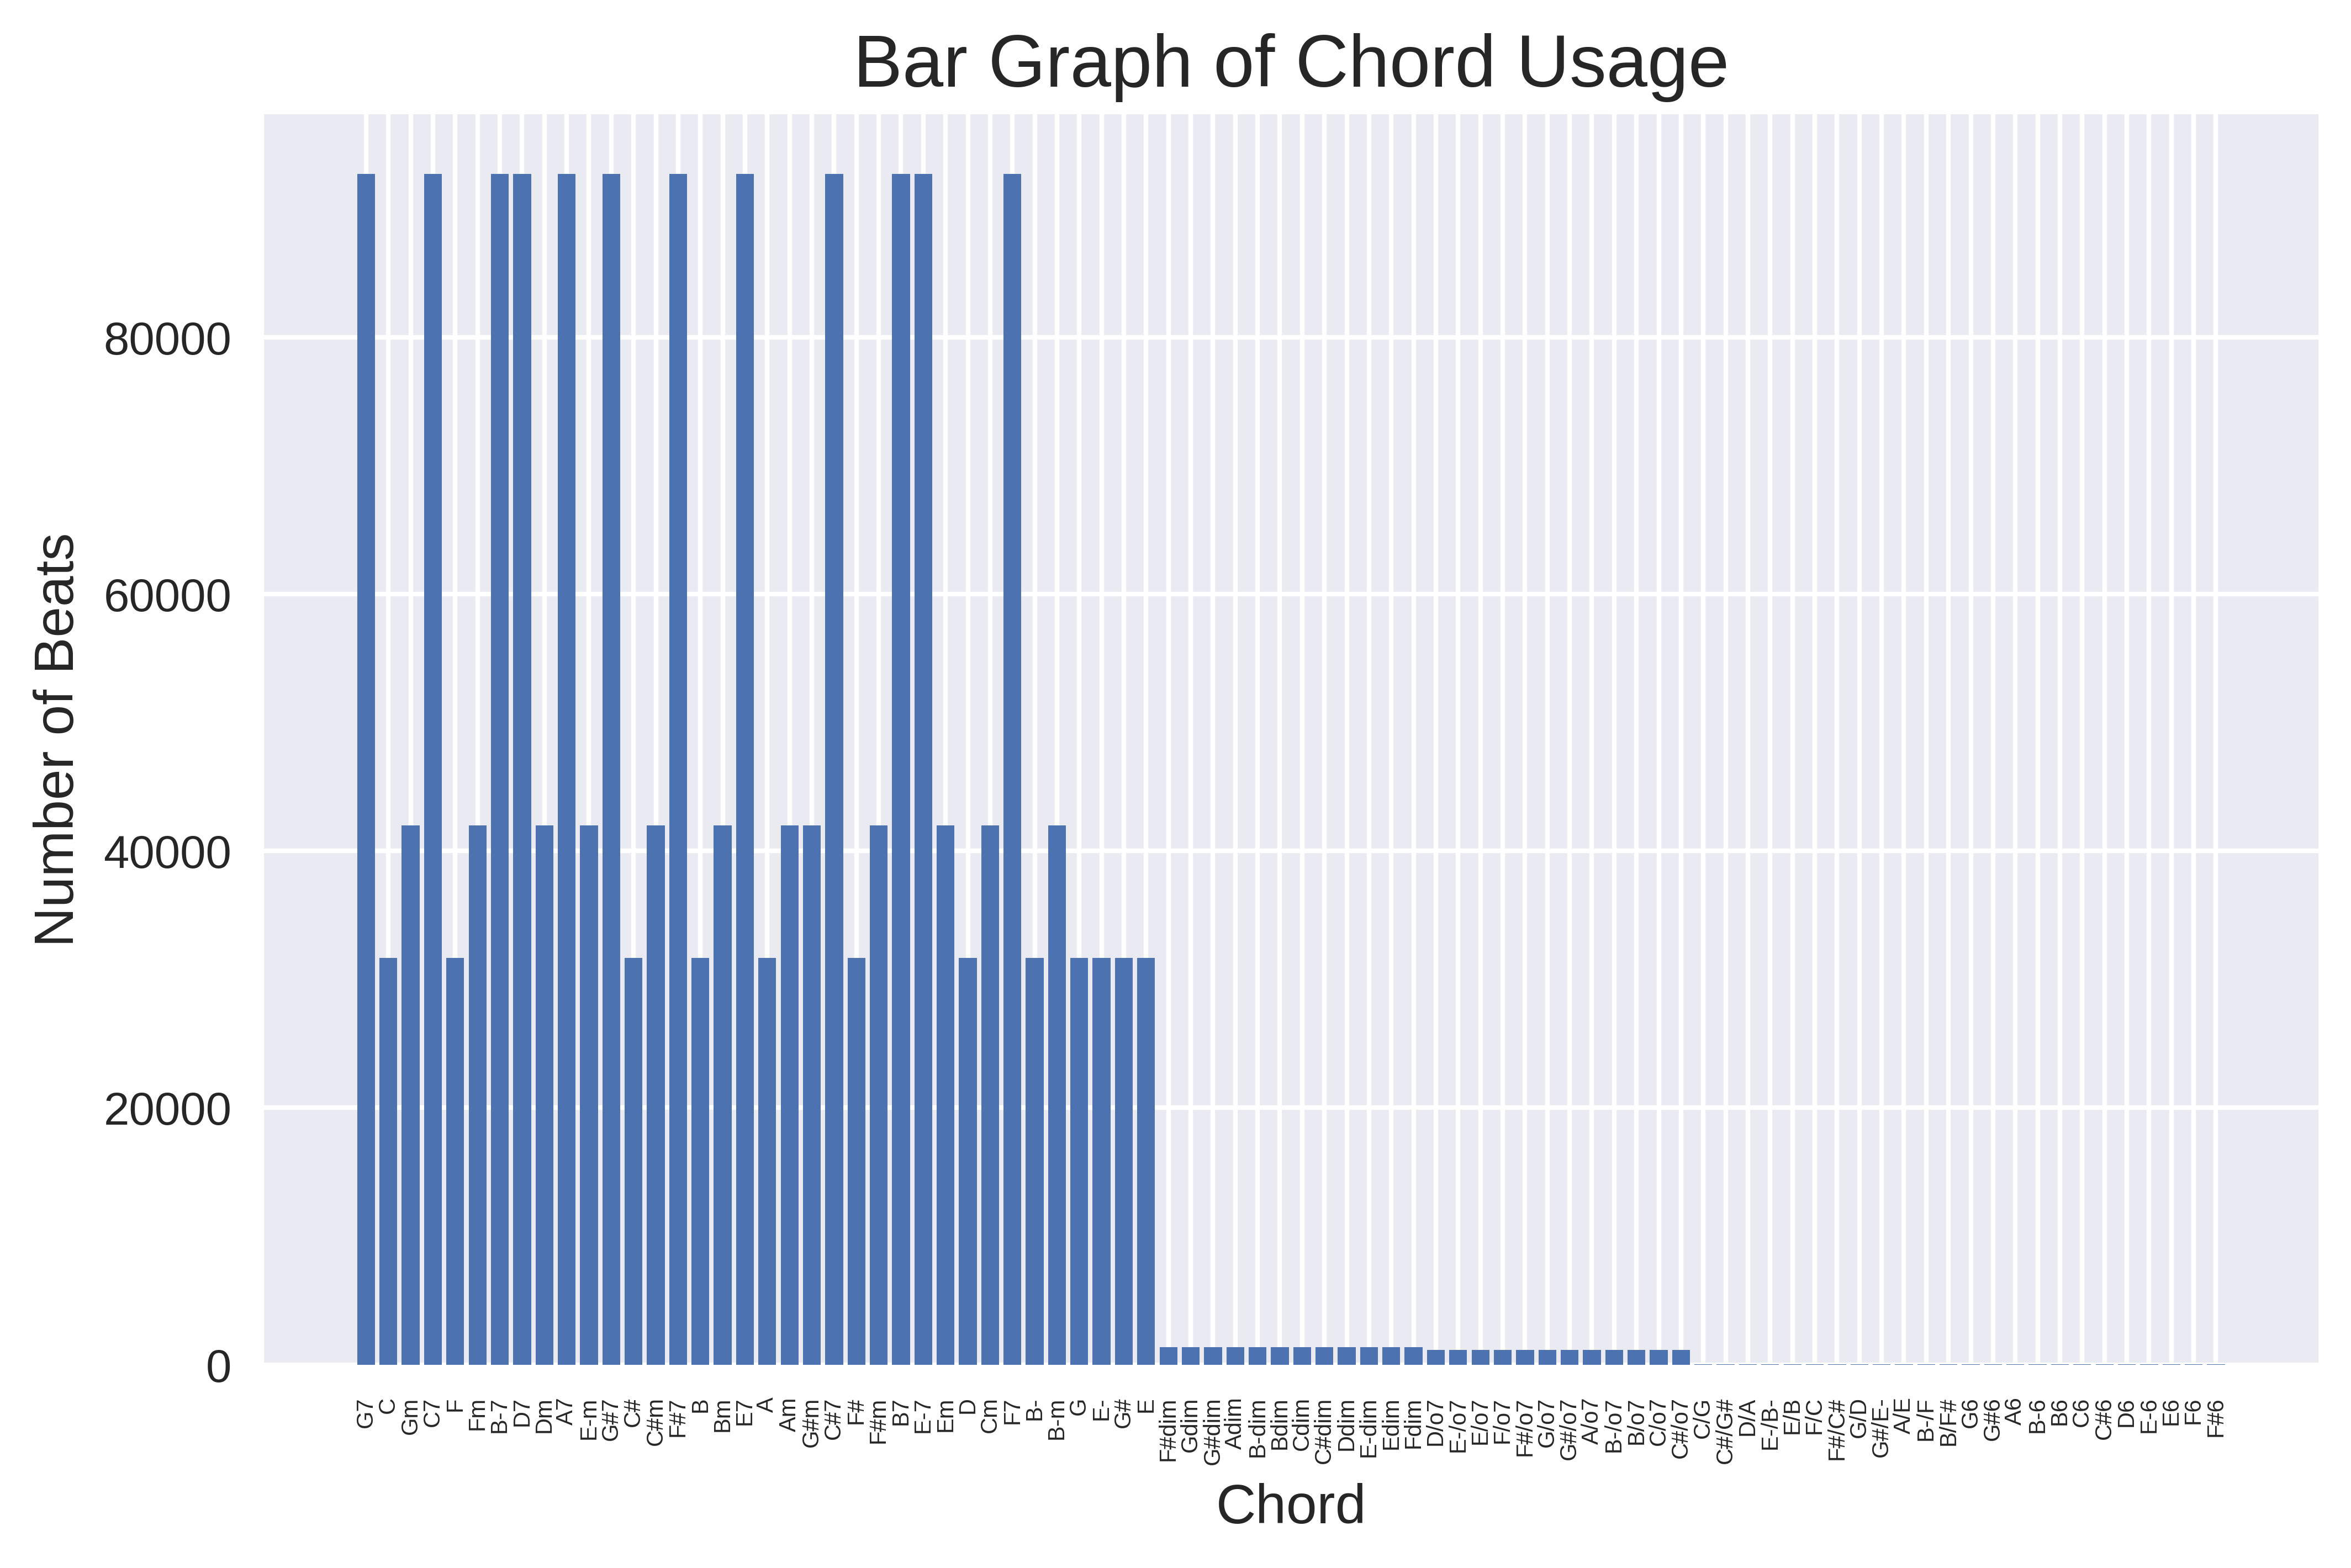

In [30]:
# Let's look at the frequency of the chords used in the songs.

x = range(len(uniqueChords))
labels = uniqueChords[0].values.tolist()

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
fig.set_dpi(300)

plt.title("Bar Graph of Chord Usage", fontsize = 16)
plt.xlabel("Chord", fontsize = 12)
plt.ylabel("Number of Beats", fontsize = 12)
plt.xticks(x, labels, fontsize = 5, rotation = "vertical")

bar = ax.bar(x, chordFrequency)

In [31]:
chordFrequency[-1]

48

# Melody Encodings

The alternatives for melody encodings have varied widely between the works I've read. Options have included:
* Piano roll of note options. (Eck)
* 18 bits for pitch, rest, sustain, and 4 octaves. (Bickerman)
* Piano roll but second half of each note is all 0s. (Lackner)
* Polyphonic - Quantized --> on/off characters --> bit vectors. (Hilscher)
* Character embeddings into char-RNN w/ barlines. (Agarwala)
* Chord generation --> Polyphonic output probabilities. (Brunner)

In terms of what's specifically feasible for my solution, polyphonic outputs should be saved for future piano solos or other challenges. For sax improvisation, we have the options:
1. Piano roll of on/off notes in sax range
2. 18 pitch/octave/rest/sustain bits to cover all notes plus sustains.
3. Piano roll but second half of notes is all 0s.
4. Character embeddings from ABC w/ barlines etc.

To start, let's check the range of the songs we now have.

## Song Range Analysis

In [0]:
def findSongMinMax(stream):
  minimumNoteValue = 500 # Obviously higher than the minimum note in the song.
  minPitch = ""
  maximumNoteValue = 0   # Obviously lower than the maximum note in the song.
  maxPitch = ""
  
  part = stream.parts[0]
    
  # Compare the notes in the song.
  for m in part:                                   # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for n in m.notes: 
        if isinstance(n, m21.note.Note):           # If this object is a note...
          pitch = n.pitch
          num = int(pitch.midi)                    # Get the note's MIDI number
            
          if (num < minimumNoteValue):
            minimumNoteValue = num
            minPitch = str(pitch.nameWithOctave)
              
          if (num > maximumNoteValue):
            maximumNoteValue = num
            maxPitch = str(pitch.nameWithOctave)
            
  return int(minimumNoteValue), int(maximumNoteValue)

In [0]:
def findRange(streams):
  minimumNoteValue = 500 # Obviously higher than the minimum note in the song.
  minPitch = ""
  maximumNoteValue = 0   # Obviously lower than the maximum note in the song.
  maxPitch = ""
  
  for s in streams:
    mn, mx = findSongMinMax(s)
    if (mn < minimumNoteValue):
      minimumNoteValue = mn
    if (mx > maximumNoteValue):
      maximumNoteValue = mx
  
  minMIDI = m21.pitch.Pitch()
  minMIDI.midi = minimumNoteValue
  minName = minMIDI.nameWithOctave
  maxMIDI = m21.pitch.Pitch()
  maxMIDI.midi = maximumNoteValue
  maxName = maxMIDI.nameWithOctave
  print("Min MIDI note:", str(minimumNoteValue) + ",", minName)
  print("Max MIDI note:", str(maximumNoteValue) + ",", maxName)
  diff = maximumNoteValue - minimumNoteValue + 1
  print("Range of", diff, "MIDI notes.")

In [0]:
def getAveragesError(streams):
  length = len(streams)
  averages = np.zeros(length)
  error = np.zeros(length)
  
  i = 0
  for s in streams:
    minimum, maximum = findSongMinMax(s)
    
    average = float(maximum + minimum) / 2.
    averages[i] = average
    
    e = average - minimum
    error[i] = e
    
    i += 1
  return averages, error

Also, we can check out the average note and also the overall range of the streams:

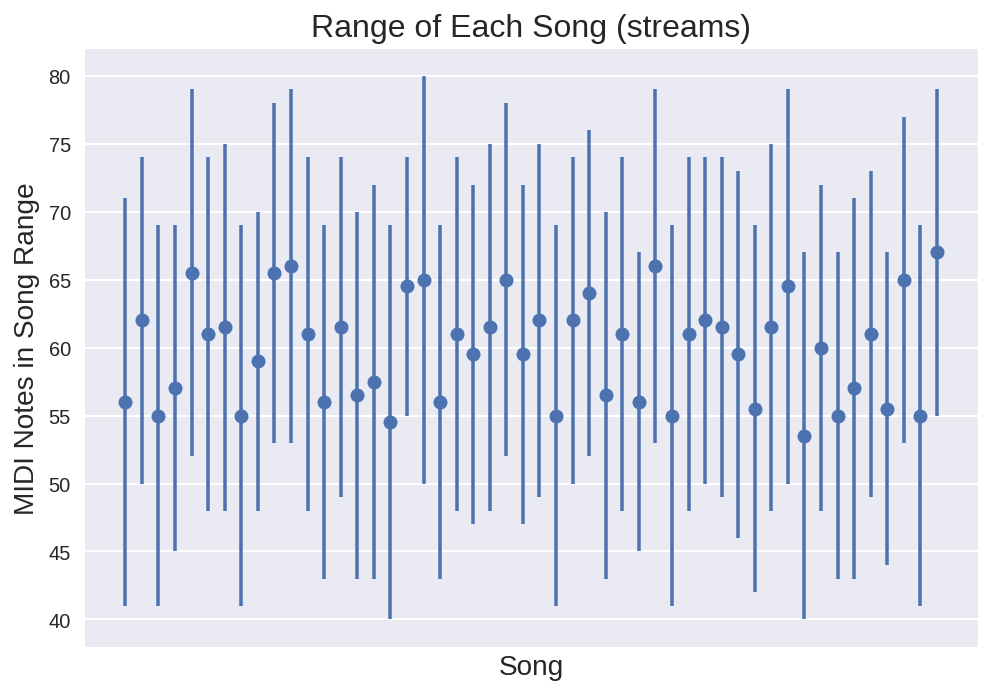

In [45]:
# Plot the original dataset version.

y, e = getAveragesError(streams)
plt.errorbar(range(len(y)), y, yerr = e, fmt = "o")

plt.title("Range of Each Song (streams)", fontsize = 16)
plt.xlabel("Song", fontsize = 14)
plt.xticks([])
plt.ylabel("MIDI Notes in Song Range", fontsize = 14)

plt.show()

In [46]:
print("Mean:", np.mean(y), "Std Dev:", np.std(y))
findRange(streams)

Mean: 59.89 Std Dev: 3.803011964219939
Min MIDI note: 40, E2
Max MIDI note: 80, G#5
Range of 41 MIDI notes.


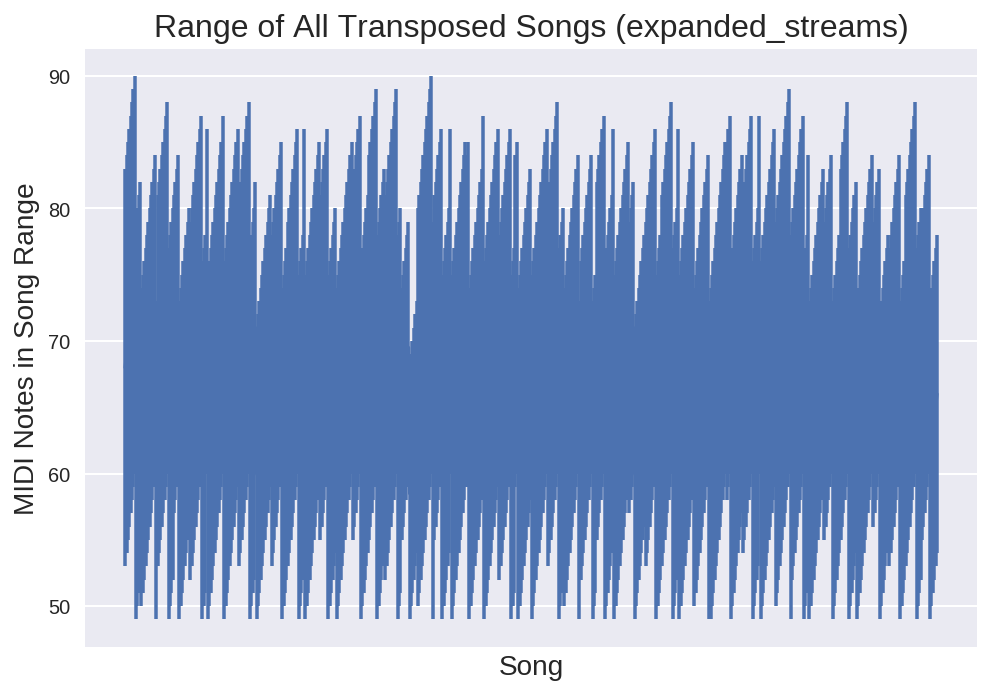

In [47]:
# Plot the transposed dataset version.

y, e = getAveragesError(expanded_streams)
plt.errorbar(range(len(y)), y, yerr = e, fmt = "")

plt.title("Range of All Transposed Songs (expanded_streams)", fontsize = 16)
plt.xlabel("Song", fontsize = 14)
plt.xticks([])
plt.ylabel("MIDI Notes in Song Range", fontsize = 14)

plt.show()

In [48]:
print("Mean:", np.mean(y), "Std Dev:", np.std(y))
findRange(expanded_streams)

Mean: 67.45 Std Dev: 3.612363030852058
Min MIDI note: 49, C#3
Max MIDI note: 90, F#6
Range of 42 MIDI notes.


We'll now transpose certain songs down in order to decrease the overall melody notes necessary to encode.

In [0]:
def fixOctave(stream):
  mn, mx = findSongMinMax(stream)
  if (mn < 49):
    stream.transpose(12, inPlace = True)
  mn, mx = findSongMinMax(stream)
  if (mn > 60):
    stream.transpose(-12, inPlace = True)
  return stream

In [0]:
finalStreams = []
for s in expanded_streams:
  newS = fixOctave(s)
  finalStreams.append(s)

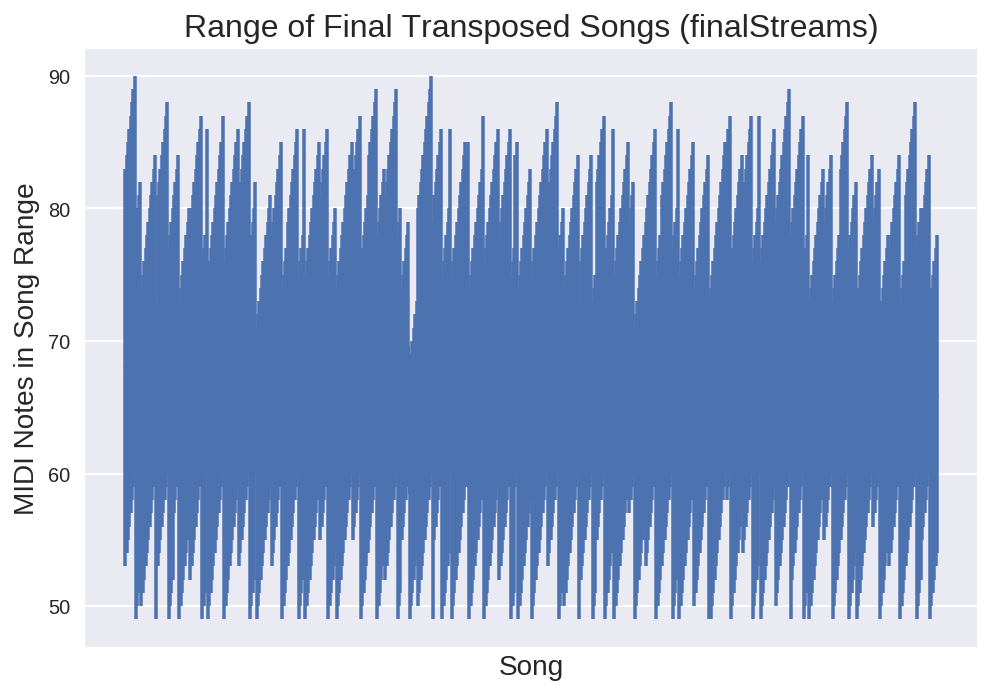

In [51]:
# Plot the transposed dataset version.

y, e = getAveragesError(finalStreams)
plt.errorbar(range(len(y)), y, yerr = e, fmt = "")

plt.title("Range of Final Transposed Songs (finalStreams)", fontsize = 16)
plt.xlabel("Song", fontsize = 14)
plt.xticks([])
plt.ylabel("MIDI Notes in Song Range", fontsize = 14)

plt.show()

In [52]:
print("Mean:", np.mean(y), "Std Dev:", np.std(y))
findRange(finalStreams)

Mean: 67.45 Std Dev: 3.612363030852058
Min MIDI note: 49, C#3
Max MIDI note: 90, F#6
Range of 42 MIDI notes.


## Melody Encodings

In [0]:
def melodyToPianoRoll(stream):
  """
  Create the 2D numpy array which will represent the notes of this song.
  NOTE: Vertical of the 2D array represents time.
        Horizontal represents the 42 possible notes for each tick.
        
  Based on the above tranpositions, I'll include 42 note options representing C#3 to F#6. This high end needs mad altissimo.
  """
  
  possible_notes = 42                # Calculated above.
  duration = getDuration(stream)
  
  ticks = int(duration * subdivide)  # The total number of "ticks" in this entire song. Exact same number as for the chords.
  
  # Create the numpy array to store the notes data.
  arr = np.zeros((ticks, possible_notes))
  
  part = stream.parts[0]
  
  # Collect the notes in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      # By reseting the offset each measure, we also insure that any errors don't cascade across the entire song.
      measureOffset = m.offset                       # This offset is in ticks.
      
      for n in m.notes:
        if isinstance(n, m21.note.Note):             # If this object is a note...
          # Its offset is the measure's plus the note's within the measure.
          noteOffset = round((n.offset + measureOffset) * subdivide)
          
          ticksInNote = int(round(n.duration.quarterLength * subdivide)) # Round in the off case of 32nd notes or something.
          endOfNote = noteOffset + ticksInNote
          
          pitch = n.pitch
          num = int(pitch.midi) - 49                 # Get the note's MIDI number and adjust it down into 0-41.
          
          for r in range(noteOffset, endOfNote):     # For each row, representing all ticks in this note...
            arr[r][num] = 1                          # Set this note's adjusted MIDI number on.
          
  return arr

In [56]:
pianoRoll = []

start = time.process_time()
for i in range(len(finalStreams)):
  s = finalStreams[i]
  arr = melodyToPianoRoll(s)
  pianoRoll.append(arr)
  if (i == 0 or i % 50 == 49):
    elapsed = "{0:.2f}".format(time.process_time() - start) 
    print("Processing melody in song", (i+1), "(" + elapsed + " seconds elapsed)")

Processing melody in song 1 (0.04 seconds elapsed)
Processing melody in song 50 (1.17 seconds elapsed)
Processing melody in song 100 (1.89 seconds elapsed)
Processing melody in song 150 (2.54 seconds elapsed)
Processing melody in song 200 (3.55 seconds elapsed)
Processing melody in song 250 (4.31 seconds elapsed)
Processing melody in song 300 (5.04 seconds elapsed)
Processing melody in song 350 (5.85 seconds elapsed)
Processing melody in song 400 (6.65 seconds elapsed)
Processing melody in song 450 (7.46 seconds elapsed)
Processing melody in song 500 (8.17 seconds elapsed)
Processing melody in song 550 (9.02 seconds elapsed)
Processing melody in song 600 (9.79 seconds elapsed)


In [0]:
def melodyTo18Bits(stream):
  """
  Create the 2D numpy array which will represent the notes of this song.
  NOTE: Vertical of the 2D array represents time.
        Horizontal represents, in order:
              * 12 bits for C-B 0-11 pitches.
              * 4 bits for octave specifier (0 is octave 3, 1 octave 4, 2 -> 5, 3 -> 6)
              * 1 bit for sustain
              * 1 bit for rest
  """
  width = 18
  duration = getDuration(stream)
  
  ticks = int(duration * subdivide)  # The total number of "ticks" in this entire song. Exact same number as for the chords.
  
  # Create the numpy array to store the notes data.
  arr = np.zeros((ticks, width))
  
  for r in range(ticks):             # Default all rests to on.
    arr[r][17] = 1
  
  part = stream.parts[0]
  
  # Collect the notes in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      # By resetting the offset each measure, we also insure that any errors don't cascade across the entire song.
      measureOffset = m.offset                       # This offset is in ticks.
      
      for n in m.notes:
        if isinstance(n, m21.note.Note):             # If this object is a note...
          # Its offset is the measure's plus the note's within the measure.
          noteOffset = round((n.offset + measureOffset) * subdivide)
          
          ticksInNote = int(round(n.duration.quarterLength * subdivide)) # Round in the off case of 32nd notes or something.
          endOfNote = noteOffset + ticksInNote
          
          # For each row, representing all ticks in this note...
          for r in range(noteOffset, endOfNote):     # Turn off all bits during the note.
            for c in range(width):
              arr[r][c] = 0
          
          p = n.pitch
          pitch = int(p.midi - 60) % 12              # pitch will range from 0 to 11.
          octave = p.octave - 3                      # Adjusted octave of the note.
          
          arr[noteOffset][pitch] = 1
          arr[noteOffset][octave + 12] = 1           # Adjust for the pitch bits.
          
          for r in range(noteOffset + 1, endOfNote):
            arr[r][16] = 1                           # Set the sustain bits to on.
          
  return arr

In [93]:
melody18bits = []

start = time.process_time()
for i in range(len(finalStreams)):
  s = finalStreams[i]
  arr = melodyTo18Bits(s)
  melody18bits.append(arr)
  if (i == 0 or i % 50 == 49):
    elapsed = "{0:.2f}".format(time.process_time() - start) 
    print("Processing melody in song", (i+1), "(" + elapsed + " seconds elapsed)")

Processing melody in song 1 (0.08 seconds elapsed)
Processing melody in song 50 (2.42 seconds elapsed)
Processing melody in song 100 (3.88 seconds elapsed)
Processing melody in song 150 (5.24 seconds elapsed)
Processing melody in song 200 (7.33 seconds elapsed)
Processing melody in song 250 (8.90 seconds elapsed)
Processing melody in song 300 (10.41 seconds elapsed)
Processing melody in song 350 (12.07 seconds elapsed)
Processing melody in song 400 (13.71 seconds elapsed)
Processing melody in song 450 (15.33 seconds elapsed)
Processing melody in song 500 (16.79 seconds elapsed)
Processing melody in song 550 (18.54 seconds elapsed)
Processing melody in song 600 (20.08 seconds elapsed)


In [0]:
def checkMelodyRows(arr, i):
  # Verifies that each row of a 2D array has at least one bit activated.
  rows = len(arr)
  cols = len(arr[0])
  
  for r in range(rows):
    pitch = False
    octave = False
    for p in range(0,12):
      if (arr[r][p] == 1):
        pitch = True
    for o in range(12,16):
      if (arr[r][o] == 1):
        octave = True
    sustain = (arr[r][16] == 1)
    rest = (arr[r][17] == 1)
    if ((pitch and (not octave)) or ((not pitch) and octave)):
      print("Invalid pitch/octave combination.", i, (r/12/4))
    if (rest and pitch):
      print("Invalid rest and pitch.", i, (r/12/4))
    if (sustain and pitch):
      print("Invalid sustain and pitch.", i, (r/12/4))
    if (rest and sustain):
      print("Invalid rest and sustain.", i, (r/12/4))
    if (not (pitch or rest or sustain)):
      print("Nothing in this row.", i, (r/12/4))

In [0]:
for i in range(len(melody18bits)):
  arr = melody18bits[i]
  checkMelodyRows(arr, i)
print("All melodies checked.")

Initially, the above 18-bit encoder had issues with 32nd notes, which caused a bit of overflow before barlines reset things. After changes were made to clear out the bits during each new note, the issue was resolved. The 18-bit encodings should now be valid.

In [82]:
finalStreams[60].show("text")

{0.0} <music21.text.TextBox "Buzzy">
{0.0} <music21.metadata.Metadata object at 0x7f9588db0a90>
{0.0} <music21.stream.Part Piano>
    {0.0} <music21.instrument.Instrument P1: Piano: Piano>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark Quarter=230.0>
        {0.0} <music21.key.KeySignature of 3 sharps>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.harmony.ChordSymbol G7>
        {0.0} <music21.note.Note B>
        {0.5} <music21.note.Note A>
        {1.0} <music21.note.Note G>
        {1.5} <music21.note.Note F#>
        {2.0} <music21.note.Note G>
        {2.5} <music21.note.Note F#>
        {3.5} <music21.note.Note A>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.harmony.ChordSymbol G7>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note G>
        {1.0} <music21.note.Rest rest>
        {2.0}